In [1]:
import os
raw_data_dir = ''

if  'COLAB_GPU' in os.environ:
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne
    !pip install pyedflib

    print('\n \n To load files from Google Drive, account validation is required.')
    #mount to drive -- files should be located in the Colab notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
else:
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'


Using homepath \Users\marit


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

import pandas as pd
import pyedflib


import tensorflow as tf
use_gpu = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)


import numpy as np

# mne imports
import mne
from mne import io

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint


# tools for plotting confusion matrices
from matplotlib import pyplot as plt

import random 
import math



C:\Users\marit\Anaconda3\lib\site-packages\numba\decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [2]:
from keras_contrib.applications import DenseNet



Using TensorFlow backend.


In [3]:

ignore_list = ['s07']  #list of patient files that should be skipped
#seconds of data to include in one slice
time_window = 12



In [25]:
mne.set_log_level("WARNING")


# get the minimum length of the files
def get_minimum_duration(group_directory_name, patient_group_file_prefix):
    file_durations = []
    for i in range (1, 15): # reading 14 files
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        file_name = raw_data_dir +'{}/{}.edf'.format(group_directory_name, patient_id)
        f = pyedflib.EdfReader(file_name)
        file_durations.append(f.file_duration)
        f.close()
    return(min(file_durations))

# modified based on https://stackoverflow.com/a/48704557/2466781
def chunk(seq, size):
    sl = len(seq) - (len(seq)%size) #exclude values that will be out of range
    r = [pd.DataFrame(seq[pos:pos + size]) for pos in range(0, sl, size)]
    return r

# modified version of process_patient_group in older notebooks
# Uses the raw EDF files and converts to dataframe, dropping the first 150 and last 30 seconds of the shortest  file
# All other files are trimmed similarly to produce the same size
# Adapted from page 1 of https://buildmedia.readthedocs.org/media/pdf/pyedflib/latest/pyedflib.pdf
def process_patient_group(group_directory_name, patient_group_file_prefix, 
                          minimum_original_duration,
                          time_window = 20,
                          plot_channels = False,
                         channels = ['F8', 'F7', 'F4', 'F3', 'Fz']):
    meta_df = pd.DataFrame()
    meta = []
    patient_id_list = []

    for i in range (1, 15): # reading 14 files
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        patient_id_list.append(patient_id)
        
        file_name = raw_data_dir + '{}/{}.edf'.format(group_directory_name, patient_id)
        data = mne.io.read_raw_edf(file_name)
        df = data.to_data_frame()
        df2 = df[channels]
        ## based on visual inspection, drop the first 120 seconds
        df2 = df2[120: (minimum_original_duration-120)]
        f = pyedflib.EdfReader(file_name)
        f.close()
        if patient_id not in ignore_list:
            meta_df = meta_df.append(df2)
            
    batches = chunk(meta_df, time_window)

    for batch in batches:
        #display(np.asarray(batch.values).shape)
        meta.append([np.asarray(batch.values)])
           
                    
    return meta
        

In [26]:
# Retrieve patient data, using a time window determined by the shortest recording
# patient s07 is removed

minimum_duration = min(get_minimum_duration("Healthy Controls", "h"), get_minimum_duration('SZ Patients', 's'))
print('Minimum duration: ', minimum_duration)

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']

target_channels = ['T4', 'T6', 'O2', 'T3', 'T5', 'O1',
                   'C4', 'P4', 'C3', 'P3', 'Cz', 'Pz']

print("Healthy Controls")
hc_data = process_patient_group('Healthy Controls', 'h', minimum_duration, channels=target_channels, time_window=time_window)
display(np.asarray(hc_data).shape)


print('Sz Patients')
sz_data = np.asarray(process_patient_group('SZ Patients', 's', minimum_duration, channels=target_channels, time_window=time_window))
display(np.asarray(sz_data).shape)


##### combine groups and create Y (labels)

X =  np.concatenate((hc_data, sz_data), axis=0)
display('Input size: ', X.shape)
y = ([0] * len(hc_data)) +( [1] * len(sz_data))




Minimum duration:  740
Healthy Controls


(583, 1, 12, 12)

Sz Patients


(541, 1, 12, 12)

'Input size: '

(1124, 1, 12, 12)

Input (X) shape: (1124, 1, 12, 12)
Preview of data. First slice of unfiltered data


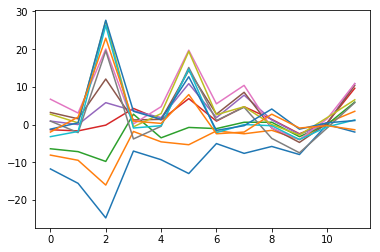

In [27]:
#X[1].plot()
from IPython.display import display

import pylab as pylab

print('Input (X) shape: ' + str(X.shape))
print('Preview of data. First slice of unfiltered data')
for el in X[1][0]:
  #print(el)
  #pylab.scatter(x=range(len(el)), y=el)
  pylab.plot(el)


In [28]:
# create the /tmp directory if it doesn't already exist
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')



In [29]:
# get a list of randomly selected sets of numbers based on a range
# the proportion of values selected for each set is determined by the ratio_array
def get_mixed_indexes_for_ml_train_test(length, ratios_array):
    input_indexes = range(0, length)
    output_indexes = []
    for ratio in ratios_array:
        selection = random.choices(input_indexes, k=math.floor(ratio * length))
        input_indexes = [i for i in input_indexes if i not in selection]
        output_indexes.append(selection)
    return output_indexes
    



In [36]:


kernels, chans, samples = 1, 12, time_window
full_size = len(X)
train_idxs, validate_idxs, test_idxs = get_mixed_indexes_for_ml_train_test(len(X), [.70, 0.15, 0.15])



X_train      = X[train_idxs][0:,]
Y_train      = np.asarray(y)[train_idxs]
X_validate   = X[validate_idxs][0:,]
Y_validate   = np.asarray(y)[validate_idxs]
X_test       = X[test_idxs][0:,]
Y_test       = np.asarray(y)[test_idxs]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train, num_classes=2)
Y_validate   = np_utils.to_categorical(Y_validate, num_classes=2)
Y_test       = np_utils.to_categorical(Y_test, num_classes=2)



X_train      = X_train.reshape(X_train.shape[0],   chans, time_window, 1)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, time_window, 1)
X_test       = X_test.reshape(X_test.shape[0], chans, time_window, 1)


 
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



#LSTM(samles, time_steps=20, input_size=30, chans)
#model = LSTM(samples=samples, time_steps=time_window, chans=chans, nb_features=1, nb_classes=2, )




# modified from https://github.com/keras-team/keras-contrib/blob/master/examples/cifar10_densenet.py

batch_size = 64
nb_classes = 2
epochs = 100

img_rows, img_cols = time_window, chans
img_channels = 1 #the number of features

# Parameters for the DenseNet model builder
if K.image_data_format() == 'channels_first':
    img_dim = (img_channels, img_rows, img_cols)
else:
    img_dim = (img_rows, img_cols, img_channels)
depth = 40 #number or layers in the DenseNet
nb_dense_block = 3
growth_rate = 6#12
nb_filter = 16
dropout_rate = 0.0  # 0.0 for data augmentation

# Create the model (without loading weights)
model = DenseNet(depth=depth, nb_dense_block=nb_dense_block,
                 growth_rate=growth_rate, nb_filter=nb_filter,
                 dropout_rate=dropout_rate,
                 input_shape=img_dim,
                 weights=None)
print('Model created')

model.summary()






#import tensorflow 
import tensorflow.keras.optimizers
opt_adam = tensorflow.keras.optimizers.Adam(lr=0.000001, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)
sgd = tensorflow.keras.optimizers.SGD(lr=0.01)



def rmse (y_true, y_pred):

    return K.sqrt(K.mean(K.square(y_pred -y_true)))


# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=[#'mse', 'mae', 
                  'accuracy', rmse
                 ])


# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/RNN_checkpoint.h5', verbose=1,
                               save_best_only=True)



X_train shape: (786, 12, 12, 1)
786 train samples
168 test samples
Model created
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 12, 12, 1)    0                                            
__________________________________________________________________________________________________
initial_conv2D (Conv2D)         (None, 12, 12, 16)   144         input_9[0][0]                    
__________________________________________________________________________________________________
dense_0_0_bn (BatchNormalizatio (None, 12, 12, 16)   64          initial_conv2D[0][0]             
__________________________________________________________________________________________________
activation_274 (Activation)     (None, 12, 12, 16)   0           dense_0_0_bn[0][0]               
____________________________

In [39]:
print('shape of X_train: ', X_train.shape)
fitted_model = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer])

#error below indicates a reduction of dimensions; it is possible that the number of channels (1) is not sufficient to support densenet
# densenet is imported from https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/applications/densenet.py
# model usage code is from here https://github.com/keras-team/keras-contrib/blob/master/examples/cifar10_densenet.py

shape of X_train:  (786, 12, 12, 1)


ValueError: Error when checking target: expected dense_8 to have 4 dimensions, but got array with shape (786, 2)

In [12]:
# load optimal weights
model.load_weights('/tmp/RNN_checkpoint.h5')



probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))



Classification accuracy: 0.809524 


Diagrammed History of Model Metrics


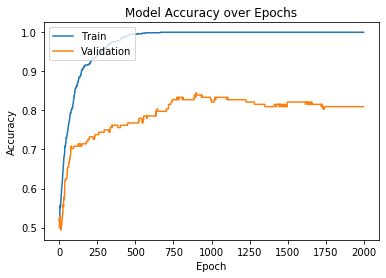

In [13]:
# list all data in history
#print(fitted_model.history.keys())

print('Diagrammed History of Model Metrics')

# summarize history for accuracy
plt.plot(fitted_model.history['acc'])
plt.plot(fitted_model.history['val_acc'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


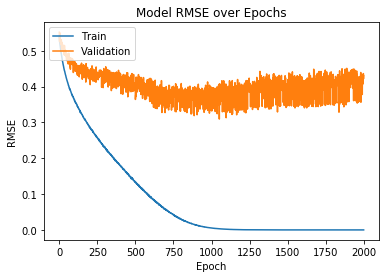

In [14]:
# summarize history for rmse
plt.plot(fitted_model.history['rmse'])
plt.plot(fitted_model.history['val_rmse'])
plt.title('Model RMSE over Epochs')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

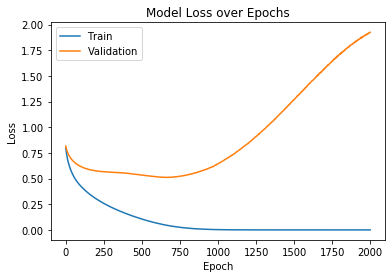

In [15]:
# summarize loss history
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
!pip freeze

absl-py==0.9.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.0.0
asgiref==3.2.3
astor==0.8.1
astropy==4.0
atari-py==0.2.6
atomicwrites==1.3.0
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.4.0
boto==2.49.0
boto3==1.10.47
botocore==1.13.47
Bottleneck==1.3.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==4.0.0
certifi==2019.11.28
cffi==1.13.2
chainer==6.5.0
chardet==3.0.4
chart-studio==1.0.0
Click==7.0
cloudpickle==1.2.2
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.0
cupy-cuda101==6.5.0
cvxopt==1.2.3
cvxpy==1.0.25
cycler==0.10.0
cymem==2.0.3
Cython==0.29.14
daft==0.0.4
dask==2.9.1
dataclasses==0.7
datascience==0.10.6
decorator==4.4.1
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.1.1
distributed==1.25.3
Django==3.0.2
dlib==19.18.0
dm-sonnet==1.3

In [17]:
from platform import python_version

print(python_version())

3.6.9
